# [Intriguing properties of neural networks](http://arxiv.org/abs/1312.6199)

​This paper reports two counter-intuitive properties:

- It is the **space**, rather than the individual units, that contains the semantic information in the high layers of neural networks.
- We can cause the network to **misclassify an image** by applying **a certain hardly perceptible perturbation**, which is found by maximizing the network’s prediction error. In addition, the specific nature of these perturbations is not a random artifact of learning: the same perturbation can cause a different network, that was trained on a different subset of the dataset, to misclassify the same input.

​We term the so perturbed examples “**adversarial examples**”. These results suggest that the deep neural networks that are learned by backpropagation have nonintuitive characteristics and intrinsic blind spots, **whose structure is connected to the data distribution in a non-obvious way**.

## Framework

For the MNIST dataset, we used a simple fully connected network with one or more hidden layers and a Softmax classifier. We refer to this network as “FC”.

In [54]:
import numpy as np

import torch
import torch.nn as nn
import torch.utils.data

import torchvision
import torchvision.utils as vutils
import torchvision.transforms as transforms
import torchvision.datasets as dset

import matplotlib.pyplot as plt
%matplotlib inline

In [55]:
mnist_train = dset.MNIST('./data', train=True, download=True, transform=transforms.ToTensor())
train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=100, shuffle=True)
mnist_test = dset.MNIST('./data', train=False, download=True, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=10000, shuffle=False)

In [56]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In order to test the cross-model generalization of adversarial examples, we define FC100_100_10 and FC10 as belows.

In [57]:
class FC100_100_10(nn.Module):
    def __init__(self):
        super(FC100_100_10, self).__init__()

        self.layer_1 = nn.Sequential(
            nn.Linear(28*28, 100),
            nn.ReLU()
        )
        
        self.layer_2 = nn.Sequential(
            nn.Linear(100, 100),
            nn.ReLU()
        )
        
        self.layer_3 = nn.Sequential(
            nn.Linear(100, 10)
        )
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        
        out_1 = self.layer_1(x)
        out_2 = self.layer_2(out_1)
        out_3 = self.layer_3(out_2)
    
        return out_3, out_2, out_1
    
class FC10(nn.Module):
    def __init__(self):
        super(FC10, self).__init__()

        self.layer_1 = nn.Sequential(
            nn.Linear(28*28, 10)
        )
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        
        out_1 = self.layer_1(x)
    
        return out_1

model_1=FC100_100_10().to(device)
model_2=FC10().to(device)

In [58]:
loss = nn.CrossEntropyLoss()
optimizer_1 = torch.optim.Adam([{'params': model_1.layer_1.parameters(), 'weight_decay': (1e-5)/100}, 
                                {'params': model_1.layer_2.parameters(), 'weight_decay': (1e-5)/100},
                                {'params': model_1.layer_3.parameters(), 'weight_decay': (1e-6)/10}], lr=0.001)
optimizer_2 = torch.optim.Adam(model_2.parameters(), lr=0.0001, weight_decay=1)


In [59]:
for epoch in range(10):
    for i, (images, labels) in enumerate(train_iter):
        X=images.to(device)
        Y=labels.to(device)

        pre,_,_=model_1(X)
        cost=loss(pre,Y)

        optimizer_1.zero_grad()
        cost.backward()
        optimizer_1.step()

        if (i+1)%100==0:
            print('epoch:[%d/%d], iter:[%d/%d], loss:%.5f' % (epoch+1,10,i+1,len(train_iter),cost.item()))
print('FC100_100_10 finished Training on the 60000 training images')

epoch:[1/10], iter:[100/600], loss:0.39643
epoch:[1/10], iter:[200/600], loss:0.36961
epoch:[1/10], iter:[300/600], loss:0.27361
epoch:[1/10], iter:[400/600], loss:0.29255
epoch:[1/10], iter:[500/600], loss:0.20346
epoch:[1/10], iter:[600/600], loss:0.17860
epoch:[2/10], iter:[100/600], loss:0.17191
epoch:[2/10], iter:[200/600], loss:0.11640
epoch:[2/10], iter:[300/600], loss:0.10855
epoch:[2/10], iter:[400/600], loss:0.14748
epoch:[2/10], iter:[500/600], loss:0.15476
epoch:[2/10], iter:[600/600], loss:0.11451
epoch:[3/10], iter:[100/600], loss:0.16640
epoch:[3/10], iter:[200/600], loss:0.14084
epoch:[3/10], iter:[300/600], loss:0.13097
epoch:[3/10], iter:[400/600], loss:0.06913
epoch:[3/10], iter:[500/600], loss:0.16847
epoch:[3/10], iter:[600/600], loss:0.05995
epoch:[4/10], iter:[100/600], loss:0.05182
epoch:[4/10], iter:[200/600], loss:0.14586
epoch:[4/10], iter:[300/600], loss:0.08332
epoch:[4/10], iter:[400/600], loss:0.04932
epoch:[4/10], iter:[500/600], loss:0.08909
epoch:[4/10

In [60]:
for epoch in range(10):
    for i, (images, labels) in enumerate(train_iter):
        X=images.to(device)
        Y=labels.to(device)

        pre=model_2(X)
        cost=loss(pre,Y)

        optimizer_2.zero_grad()
        cost.backward()
        optimizer_2.step()

        if (i+1)%100==0:
            print('epoch:[%d/%d], iter:[%d/%d], loss:%.5f' % (epoch+1,10,i+1,len(train_iter),cost.item()))
print('FC10 finished Training on the 60000 training images')

epoch:[1/10], iter:[100/600], loss:2.11946
epoch:[1/10], iter:[200/600], loss:1.96736
epoch:[1/10], iter:[300/600], loss:1.88574
epoch:[1/10], iter:[400/600], loss:1.73668
epoch:[1/10], iter:[500/600], loss:1.70436
epoch:[1/10], iter:[600/600], loss:1.72785
epoch:[2/10], iter:[100/600], loss:1.67791
epoch:[2/10], iter:[200/600], loss:1.63790
epoch:[2/10], iter:[300/600], loss:1.66724
epoch:[2/10], iter:[400/600], loss:1.64725
epoch:[2/10], iter:[500/600], loss:1.62047
epoch:[2/10], iter:[600/600], loss:1.59427
epoch:[3/10], iter:[100/600], loss:1.61706
epoch:[3/10], iter:[200/600], loss:1.59543
epoch:[3/10], iter:[300/600], loss:1.60943
epoch:[3/10], iter:[400/600], loss:1.62477
epoch:[3/10], iter:[500/600], loss:1.69734
epoch:[3/10], iter:[600/600], loss:1.61668
epoch:[4/10], iter:[100/600], loss:1.64551
epoch:[4/10], iter:[200/600], loss:1.61610
epoch:[4/10], iter:[300/600], loss:1.61433
epoch:[4/10], iter:[400/600], loss:1.54928
epoch:[4/10], iter:[500/600], loss:1.65813
epoch:[4/10

In [61]:
model_1.eval()

total = 0
correct = 0

for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    
    outputs,_,_ = model_1(images)
    # torch.max(outputs.data, 1)输出每一行的最大值(value, index)
    _,predicted = torch.max(outputs.data, dim=1)

    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of FC100_100_10 on the 10000 test images: %f %%' % (100 * correct / total))

Accuracy of FC100_100_10 on the 10000 test images: 97.329994 %


In [62]:
model_2.eval()

total = 0
correct = 0

for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    
    outputs = model_2(images)
    # torch.max(outputs.data, 1)输出每一行的最大值(value, index)
    _,predicted = torch.max(outputs.data, dim=1)

    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of FC10 on the 10000 test images: %f %%' % (100 * correct / total))

Accuracy of FC10 on the 10000 test images: 79.869995 %


## Units of $φ(x)$

Visual inspection of images $x′$, which satisfy (or are close to maximum attainable value):

$$
x′ = \arg \underset{x \in \mathcal{I}} {max} <φ(x),v>
$$


In [63]:
def imshow(img):
    image = img.cpu().clone().numpy()
    plt.figure(figsize=(10, 20))
    # image -> (channel, row, col)
    # plt.imshow(row,col,channel)
    plt.imshow(np.transpose(image, (1, 2, 0)))
    plt.axis('off')
    plt.show()

### in the natural basis direction

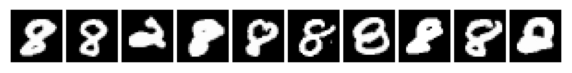

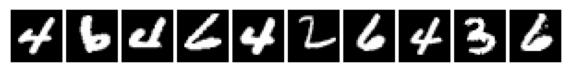

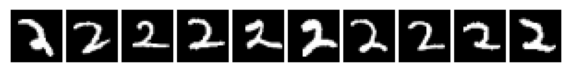

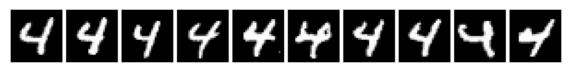

In [64]:
for i in range(4):
    unit = torch.eye(100)[i,:]

    for images, labels in test_loader:
        images = images.to(device)
        
        _,phi_x,_ = model_1(images)
        values=torch.mv(phi_x.cpu(),unit)
    
    top_index = np.argsort(values.data.numpy())[-10:]
    top_image= images[top_index]
        
    imshow(torchvision.utils.make_grid(top_image, normalize=True, pad_value=1, nrow=10))

### in a random basis

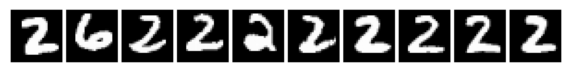

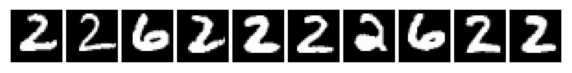

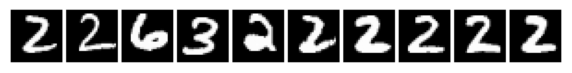

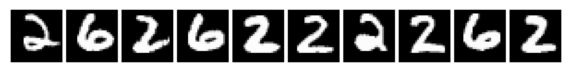

In [65]:
for i in range(4):
    direction= torch.rand(100)
    
    for images, labels in test_loader:
        images = images.to(device)
        
        _,phi_x,_ = model_1(images)
        values=torch.mv(phi_x.cpu(),direction)
    
    top_index = np.argsort(values.data.numpy())[-10:]
    top_image= images[top_index]
        
    imshow(torchvision.utils.make_grid(top_image, normalize=True, pad_value=1, nrow=10))

The experiment suggests that the natural basis is not better than a random basis for inspecting the properties of $φ(x)$. This puts into question the notion that neural networks disentangle variation factors across coordinates.

## Blind Spots in Neural Networks(“**adversarial examples**”)

For a small enough radius $ε > 0$ in the vicinity of a given training input $x$, an $x + r$ satisfying $||r|| < ε$ will get assigned a high probability of the correct class by the model. This kind of **smoothness prior** is typically valid for computer vision problems. In general, imperceptibly tiny perturbations of a given image do not normally change the underlying class.

Our main result is that for deep neural networks, the smoothness assumption that underlies many kernel methods does not hold. Specifically, we show that by using a simple optimization procedure, we are able to find adversarial examples, which are obtained by imperceptibly small perturbations to a correctly classified input image, so that it is no longer classified correctly.


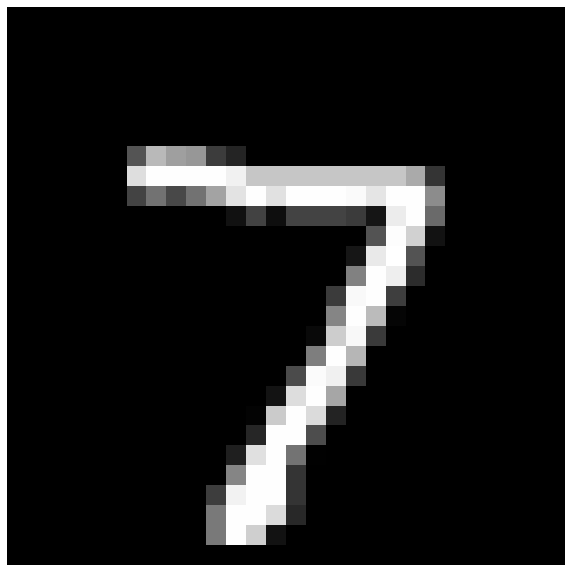

In [66]:
sample_img=mnist_test[0][0].cuda()
output,_,_=model_1(sample_img.to(device))
_,prediction=torch.max(output.data,1)
imshow(torchvision.utils.make_grid(sample_img, normalize=True))

In [67]:
def distortion(a,b):
    return torch.sqrt(torch.sum((a-b)**2)/784)

We aim to solve the following box-constrained optimization problem:

$$
\min ||r||_{2} \\s.t. \quad f(x+r)=l \\ \qquad \qquad x+r \in [0,1]^{m}
$$

or:

$$
\min c||r||_{2}+loss_{f}(x+r,l) \quad s.t. \quad x+r \in [0,1]^{m}
$$

In [68]:
right=sample_img-torch.zeros_like(sample_img).cuda()

left=sample_img-torch.ones_like(sample_img).cuda()

m=100

According to our initial observations, adversarial examples for the higher layers seemed to be significantly more useful than those on the input or lower layers. In our future work, we plan to compare these effects in a systematic manner.

Adversarial examples have the following intriguing properties:

1. For each sample, we have always managed to generate very close, visually hard to distinguish, adversarial examples that are misclassified by the original network. 

num: 0, epoch: [100/1000], prediction: 0, loss_adv: 125.53252
num: 0, epoch: [200/1000], prediction: 0, loss_adv: 108.79788
num: 0, epoch: [300/1000], prediction: 0, loss_adv: 95.00357
num: 0, epoch: [400/1000], prediction: 0, loss_adv: 81.29201
num: 0, epoch: [500/1000], prediction: 0, loss_adv: 67.50618
num: 0, epoch: [600/1000], prediction: 0, loss_adv: 53.65933
num: 0, epoch: [700/1000], prediction: 0, loss_adv: 39.76553
num: 0, epoch: [800/1000], prediction: 0, loss_adv: 25.83137
num: 0, epoch: [900/1000], prediction: 0, loss_adv: 11.85730
Attack success! The number is 0 and the distortion is 0.099772


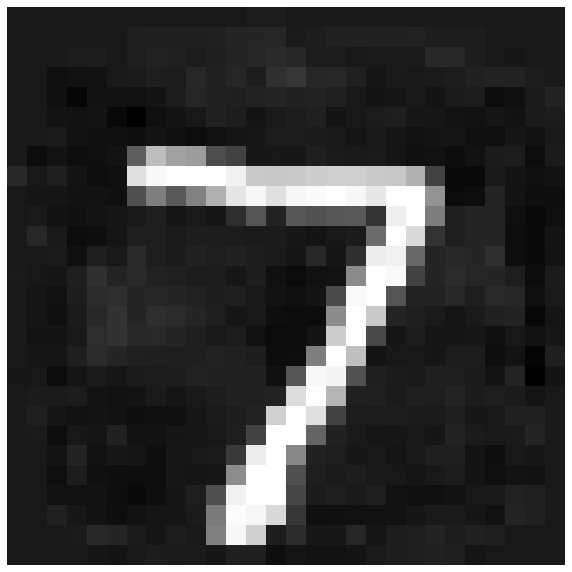

num: 1, epoch: [100/1000], prediction: 1, loss_adv: 19.65036
num: 1, epoch: [200/1000], prediction: 1, loss_adv: 4.42152
num: 1, epoch: [300/1000], prediction: 1, loss_adv: 0.01240
num: 1, epoch: [400/1000], prediction: 1, loss_adv: 0.01005
num: 1, epoch: [500/1000], prediction: 1, loss_adv: 0.04282
num: 1, epoch: [600/1000], prediction: 1, loss_adv: 0.01690
num: 1, epoch: [700/1000], prediction: 1, loss_adv: 0.02413
num: 1, epoch: [800/1000], prediction: 1, loss_adv: 0.00317
num: 1, epoch: [900/1000], prediction: 1, loss_adv: 0.02034
Attack success! The number is 1 and the distortion is 0.113864


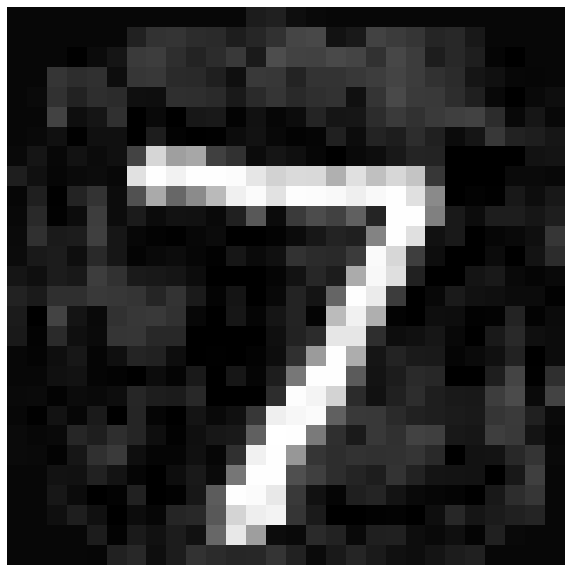

num: 2, epoch: [100/1000], prediction: 2, loss_adv: 34.54792
num: 2, epoch: [200/1000], prediction: 2, loss_adv: 19.77607
num: 2, epoch: [300/1000], prediction: 2, loss_adv: 6.18350
num: 2, epoch: [400/1000], prediction: 2, loss_adv: 0.01868
num: 2, epoch: [500/1000], prediction: 2, loss_adv: 0.02238
num: 2, epoch: [600/1000], prediction: 2, loss_adv: 0.01043
num: 2, epoch: [700/1000], prediction: 2, loss_adv: 0.01870
num: 2, epoch: [800/1000], prediction: 2, loss_adv: 0.02169
num: 2, epoch: [900/1000], prediction: 2, loss_adv: 0.01013
Attack success! The number is 2 and the distortion is 0.097735


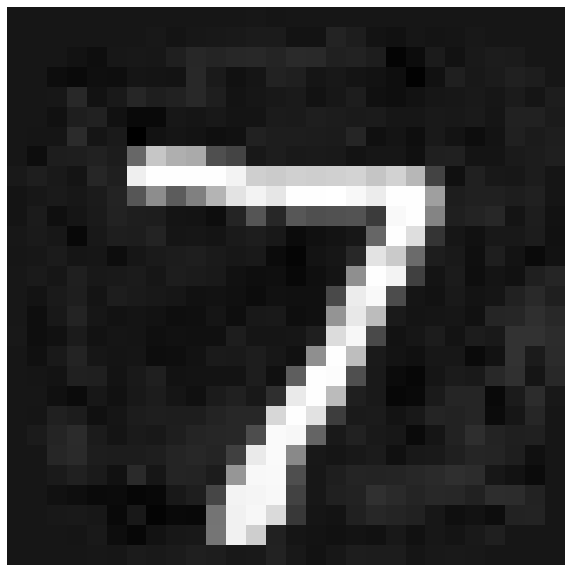

num: 3, epoch: [100/1000], prediction: 3, loss_adv: 17.58777
num: 3, epoch: [200/1000], prediction: 3, loss_adv: 2.96009
num: 3, epoch: [300/1000], prediction: 3, loss_adv: 0.00173
num: 3, epoch: [400/1000], prediction: 3, loss_adv: 0.01618
num: 3, epoch: [500/1000], prediction: 3, loss_adv: 0.02245
num: 3, epoch: [600/1000], prediction: 3, loss_adv: 0.00956
num: 3, epoch: [700/1000], prediction: 3, loss_adv: 0.00786
num: 3, epoch: [800/1000], prediction: 3, loss_adv: 0.03263
num: 3, epoch: [900/1000], prediction: 3, loss_adv: 0.03823
Attack success! The number is 3 and the distortion is 0.095646


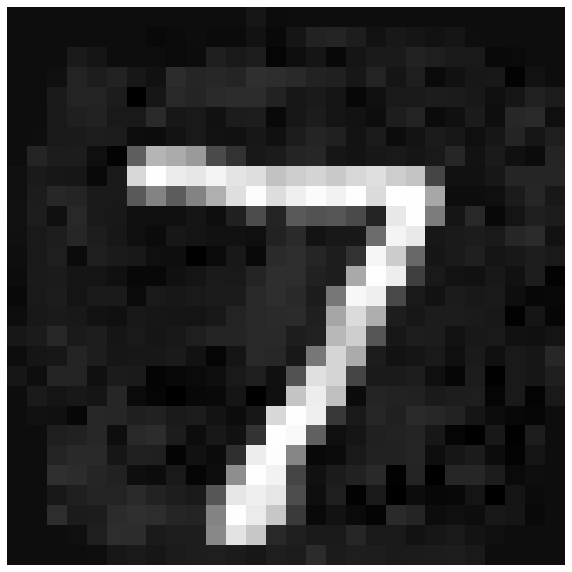

num: 4, epoch: [100/1000], prediction: 4, loss_adv: 32.57664
num: 4, epoch: [200/1000], prediction: 4, loss_adv: 16.57531
num: 4, epoch: [300/1000], prediction: 4, loss_adv: 2.00918
num: 4, epoch: [400/1000], prediction: 4, loss_adv: 0.01559
num: 4, epoch: [500/1000], prediction: 4, loss_adv: 0.01395
num: 4, epoch: [600/1000], prediction: 4, loss_adv: 0.01333
num: 4, epoch: [700/1000], prediction: 4, loss_adv: 0.01299
num: 4, epoch: [800/1000], prediction: 4, loss_adv: 0.01278
num: 4, epoch: [900/1000], prediction: 4, loss_adv: 0.01265
Attack success! The number is 4 and the distortion is 0.091445


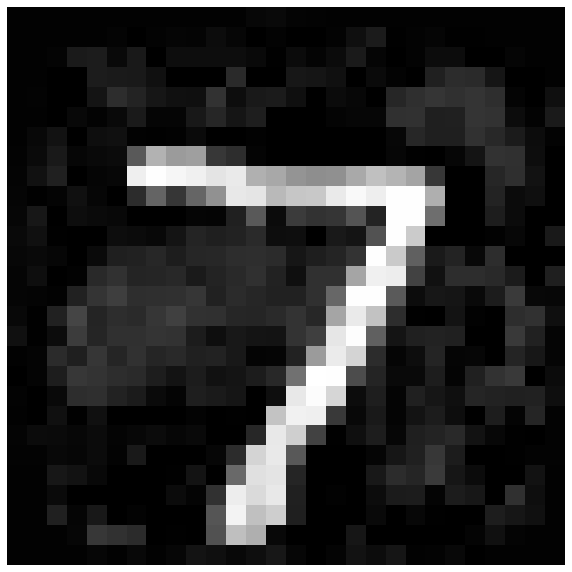

num: 5, epoch: [100/1000], prediction: 5, loss_adv: 1807.46387
num: 5, epoch: [200/1000], prediction: 5, loss_adv: 1773.68933
num: 5, epoch: [300/1000], prediction: 5, loss_adv: 1758.03979
num: 5, epoch: [400/1000], prediction: 5, loss_adv: 1744.04309
num: 5, epoch: [500/1000], prediction: 5, loss_adv: 1730.20850
num: 5, epoch: [600/1000], prediction: 5, loss_adv: 1716.35400
num: 5, epoch: [700/1000], prediction: 5, loss_adv: 1702.47107
num: 5, epoch: [800/1000], prediction: 5, loss_adv: 1688.56580
num: 5, epoch: [900/1000], prediction: 5, loss_adv: 1674.64441
Attack success! The number is 5 and the distortion is 0.144441


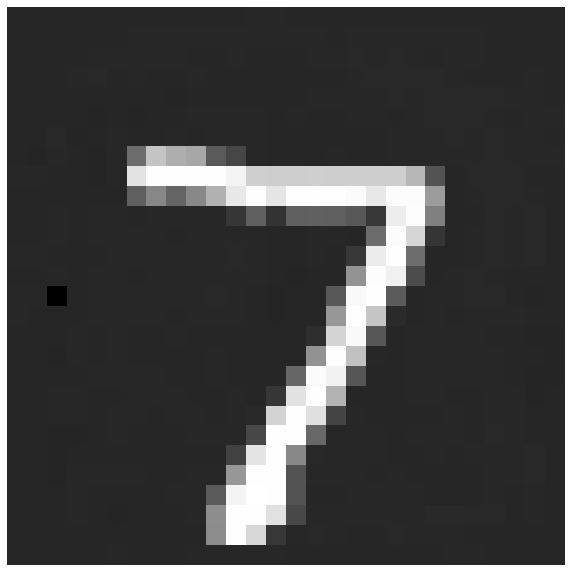

num: 6, epoch: [100/1000], prediction: 6, loss_adv: 39.55859
num: 6, epoch: [200/1000], prediction: 6, loss_adv: 23.37741
num: 6, epoch: [300/1000], prediction: 6, loss_adv: 9.10738
num: 6, epoch: [400/1000], prediction: 6, loss_adv: 0.08614
num: 6, epoch: [500/1000], prediction: 6, loss_adv: 0.00332
num: 6, epoch: [600/1000], prediction: 6, loss_adv: 0.00712
num: 6, epoch: [700/1000], prediction: 6, loss_adv: 0.02408
num: 6, epoch: [800/1000], prediction: 6, loss_adv: 0.01970
num: 6, epoch: [900/1000], prediction: 6, loss_adv: 0.02557
Attack success! The number is 6 and the distortion is 0.110787


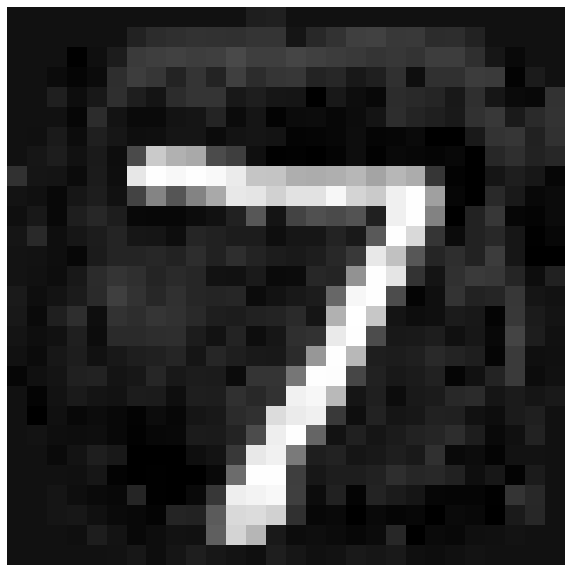

num: 7, epoch: [100/1000], prediction: 7, loss_adv: 33.95977
num: 7, epoch: [200/1000], prediction: 7, loss_adv: 20.18001
num: 7, epoch: [300/1000], prediction: 7, loss_adv: 6.52837
num: 7, epoch: [400/1000], prediction: 7, loss_adv: 0.00886
num: 7, epoch: [500/1000], prediction: 7, loss_adv: 0.02732
num: 7, epoch: [600/1000], prediction: 7, loss_adv: 0.00030
num: 7, epoch: [700/1000], prediction: 7, loss_adv: 0.00337
num: 7, epoch: [800/1000], prediction: 7, loss_adv: 0.02736
num: 7, epoch: [900/1000], prediction: 7, loss_adv: 0.00032
num: 8, epoch: [100/1000], prediction: 8, loss_adv: 101.20991
num: 8, epoch: [200/1000], prediction: 8, loss_adv: 84.86412
num: 8, epoch: [300/1000], prediction: 8, loss_adv: 71.06105
num: 8, epoch: [400/1000], prediction: 8, loss_adv: 57.35004
num: 8, epoch: [500/1000], prediction: 8, loss_adv: 43.56168
num: 8, epoch: [600/1000], prediction: 8, loss_adv: 29.70351
num: 8, epoch: [700/1000], prediction: 8, loss_adv: 15.78709
num: 8, epoch: [800/1000], pre

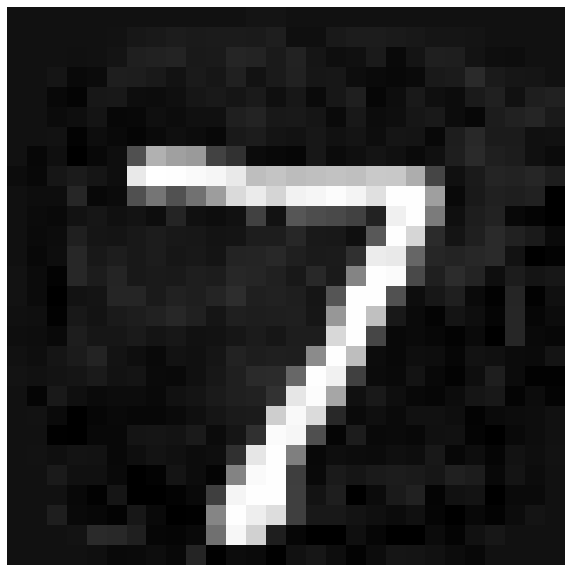

num: 9, epoch: [100/1000], prediction: 9, loss_adv: 52.42906
num: 9, epoch: [200/1000], prediction: 9, loss_adv: 36.84373
num: 9, epoch: [300/1000], prediction: 9, loss_adv: 23.08985
num: 9, epoch: [400/1000], prediction: 9, loss_adv: 9.42193
num: 9, epoch: [500/1000], prediction: 9, loss_adv: 0.04709
num: 9, epoch: [600/1000], prediction: 9, loss_adv: 0.02015
num: 9, epoch: [700/1000], prediction: 9, loss_adv: 0.02575
num: 9, epoch: [800/1000], prediction: 9, loss_adv: 0.00385
num: 9, epoch: [900/1000], prediction: 9, loss_adv: 0.01852
Attack success! The number is 9 and the distortion is 0.067039


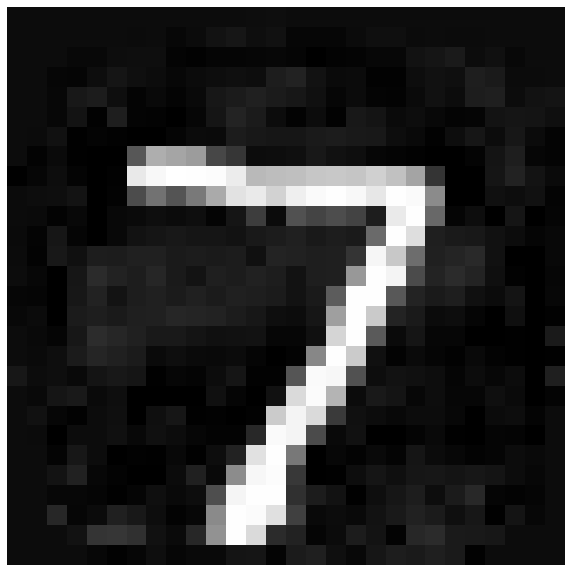

In [69]:
for num in range(10):

    r = torch.zeros_like(sample_img).cuda()
    r.requires_grad = True
    
    c = torch.rand(1).cuda()
    c = 1 / (c + 1e-10)
    c.requires_grad = True

    #optimizer_adv = torch.optim.LBFGS([r, c], lr=0.01 , line_search_fn='strong_wolfe', history_size=m)
    optimizer_adv = torch.optim.Adam([r, c], lr=0.005)
    
    for i in range(1000):

        X = sample_img.cuda() + r.cuda()
        X = (X - torch.min(X)) / (torch.max(X) - torch.min(X))
        Y = torch.tensor([num]).cuda()

        output,_,_ = model_1(X)
        _,prediction = torch.max(output.data,1)

        cost = torch.norm(r-left, p=2).cuda() + torch.norm(right-r, p=2).cuda()
        loss_adv= c.abs() * cost + loss(output,Y)

        def closure():
            return loss_adv
        
        optimizer_adv.zero_grad()
        loss_adv.backward(retain_graph=True)
        optimizer_adv.step(closure=closure)


        if (i+1) == 1000:

            if prediction.item() != 7 and prediction.item() == num:

                print('Attack success! The number is %d and the distortion is %f' % (prediction.item(), distortion(X, sample_img).item()))
                imshow(torchvision.utils.make_grid(X.data.cpu(), normalize=True))

        elif (i+1) % 100 == 0:
            print('num: %d, epoch: [%d/%d], prediction: %d, loss_adv: %.5f' % (num, i+1, 1000, prediction.item(), loss_adv.item()))

2. Cross model generalization: a relatively large fraction of examples will be misclassified by networks trained from scratch with different hyper-parameters (number of layers, regularization or initial weights). 

In [78]:
error=0
nums=0
for (sample_img, sample_num) in mnist_test:
    if nums >= 100:
        break

    sample_img=sample_img.cuda()
    for num in range(10):

        r = torch.zeros_like(sample_img).cuda()
        r.requires_grad = True
    
        c = torch.rand(1).cuda()
        c = 1 / (c + 1e-10)
        c.requires_grad = True

        #optimizer_adv = torch.optim.LBFGS([r, c], lr=0.01 , line_search_fn='strong_wolfe', history_size=m)
        optimizer_adv = torch.optim.Adam([r, c], lr=0.005)
    
        for i in range(1000):

            X = sample_img.cuda() + r.cuda()
            X = (X - torch.min(X)) / (torch.max(X) - torch.min(X))
            Y = torch.tensor([num]).cuda()

            output,_,_ = model_1(X)
            _,prediction = torch.max(output.data,1)

            cost = torch.norm(r-left, p=2).cuda() + torch.norm(right-r, p=2).cuda()
            loss_adv= c.abs() * cost + loss(output,Y)

            def closure():
                return loss_adv
        
            optimizer_adv.zero_grad()
            loss_adv.backward(retain_graph=True)
            optimizer_adv.step(closure=closure)


            if (i+1) == 1000:

                if prediction.item() != sample_num and prediction.item() == num:

                    nums += 1

                    o = model_2(X)
                    # torch.max(outputs.data, 1)输出每一行的最大值(value, index)
                    _,p_2 = torch.max(o.data, dim=1)

                    if p_2.item() != sample_num:
                        
                        error += 1
                        print('Attack success! %d is %d for model_1 and %d for model_2' % (sample_num, prediction.item(), p_2.item()))
error/nums

Attack success! 2 is 0 for model_1 and 0 for model_2
Attack success! 2 is 3 for model_1 and 3 for model_2
Attack success! 1 is 0 for model_1 and 7 for model_2
Attack success! 1 is 2 for model_1 and 7 for model_2
Attack success! 1 is 3 for model_1 and 7 for model_2
Attack success! 1 is 5 for model_1 and 7 for model_2
Attack success! 1 is 6 for model_1 and 7 for model_2
Attack success! 1 is 7 for model_1 and 7 for model_2
Attack success! 1 is 8 for model_1 and 7 for model_2
Attack success! 0 is 3 for model_1 and 7 for model_2
Attack success! 4 is 0 for model_1 and 7 for model_2
Attack success! 4 is 1 for model_1 and 7 for model_2
Attack success! 4 is 2 for model_1 and 7 for model_2
Attack success! 4 is 3 for model_1 and 7 for model_2
Attack success! 4 is 5 for model_1 and 7 for model_2
Attack success! 4 is 6 for model_1 and 7 for model_2
Attack success! 4 is 7 for model_1 and 7 for model_2
Attack success! 4 is 8 for model_1 and 7 for model_2
Attack success! 4 is 9 for model_1 and 7 for m

0.6699029126213593

3. Cross training-set generalization a relatively large fraction of examples will be misclassified by networks trained from scratch on a disjoint training set.

In [79]:
model_3=FC100_100_10().to(device)
model_4=FC100_100_10().to(device)

In [80]:
n=len(mnist_train)
train_ds1, train_ds2 = torch.utils.data.random_split(mnist_train, [int(n/2), n-int(n/2)])
train_loader1 = torch.utils.data.DataLoader(train_ds1, batch_size=100, shuffle=True)
train_loader2 = torch.utils.data.DataLoader(train_ds2, batch_size=100, shuffle=True)

In [81]:
for epoch in range(10):

    for i, (images, labels) in enumerate(train_loader1):

        X=images.to(device)
        Y=labels.to(device)

        pre,_,_=model_3(X)
        cost=loss(pre,Y)

        optimizer_1.zero_grad()
        cost.backward()
        optimizer_1.step()

        if (i+1)%100==0:
            print('epoch:[%d/%d], iter:[%d/%d], loss:%.5f' % (epoch+1,10,i+1,len(train_iter),cost.item()))
print('FC100_100_10 finished Training on the 30000 training images')

model_3.eval()

epoch:[1/10], iter:[100/600], loss:2.30671
epoch:[1/10], iter:[200/600], loss:2.30295
epoch:[1/10], iter:[300/600], loss:2.30372
epoch:[2/10], iter:[100/600], loss:2.30854
epoch:[2/10], iter:[200/600], loss:2.30985
epoch:[2/10], iter:[300/600], loss:2.31048
epoch:[3/10], iter:[100/600], loss:2.30324
epoch:[3/10], iter:[200/600], loss:2.30586
epoch:[3/10], iter:[300/600], loss:2.32007
epoch:[4/10], iter:[100/600], loss:2.30821
epoch:[4/10], iter:[200/600], loss:2.31483
epoch:[4/10], iter:[300/600], loss:2.30666
epoch:[5/10], iter:[100/600], loss:2.31355
epoch:[5/10], iter:[200/600], loss:2.32432
epoch:[5/10], iter:[300/600], loss:2.30216
epoch:[6/10], iter:[100/600], loss:2.30294
epoch:[6/10], iter:[200/600], loss:2.31043
epoch:[6/10], iter:[300/600], loss:2.31774
epoch:[7/10], iter:[100/600], loss:2.30565
epoch:[7/10], iter:[200/600], loss:2.30717
epoch:[7/10], iter:[300/600], loss:2.31000
epoch:[8/10], iter:[100/600], loss:2.29810
epoch:[8/10], iter:[200/600], loss:2.30809
epoch:[8/10

In [82]:
for epoch in range(10):
    for i, (images, labels) in enumerate(train_loader2):
        X=images.to(device)
        Y=labels.to(device)

        pre,_,_=model_4(X)
        cost=loss(pre,Y)

        optimizer_1.zero_grad()
        cost.backward()
        optimizer_1.step()

        if (i+1)%100==0:
            print('epoch:[%d/%d], iter:[%d/%d], loss:%.5f' % (epoch+1,10,i+1,len(train_iter),cost.item()))
print('FC100_100_10\' finished Training on the 30000 training images')
model_4.eval()

epoch:[1/10], iter:[100/600], loss:2.31373
epoch:[1/10], iter:[200/600], loss:2.28985
epoch:[1/10], iter:[300/600], loss:2.29390
epoch:[2/10], iter:[100/600], loss:2.29620
epoch:[2/10], iter:[200/600], loss:2.31147
epoch:[2/10], iter:[300/600], loss:2.30864
epoch:[3/10], iter:[100/600], loss:2.30020
epoch:[3/10], iter:[200/600], loss:2.28780
epoch:[3/10], iter:[300/600], loss:2.30039
epoch:[4/10], iter:[100/600], loss:2.30039
epoch:[4/10], iter:[200/600], loss:2.29093
epoch:[4/10], iter:[300/600], loss:2.30850
epoch:[5/10], iter:[100/600], loss:2.30621
epoch:[5/10], iter:[200/600], loss:2.28993
epoch:[5/10], iter:[300/600], loss:2.30700
epoch:[6/10], iter:[100/600], loss:2.30220
epoch:[6/10], iter:[200/600], loss:2.30212
epoch:[6/10], iter:[300/600], loss:2.30088
epoch:[7/10], iter:[100/600], loss:2.29604
epoch:[7/10], iter:[200/600], loss:2.29685
epoch:[7/10], iter:[300/600], loss:2.30050
epoch:[8/10], iter:[100/600], loss:2.30529
epoch:[8/10], iter:[200/600], loss:2.29620
epoch:[8/10

In [87]:
error=0
nums=0
for (sample_img, sample_num) in mnist_test:
    
    if nums >= 100:
        break

    sample_img=sample_img.cuda()
    for num in range(10):

        r = torch.zeros_like(sample_img).cuda()
        r.requires_grad = True
    
        c = torch.rand(1).cuda()
        c = 1 / (c + 1e-10)
        c.requires_grad = True

        #optimizer_adv = torch.optim.LBFGS([r, c], lr=0.01 , line_search_fn='strong_wolfe', history_size=m)
        optimizer_adv = torch.optim.Adam([r, c], lr=0.005)
    
        for i in range(1000):

            X = sample_img.cuda() + r.cuda()
            X = (X - torch.min(X)) / (torch.max(X) - torch.min(X))
            Y = torch.tensor([num]).cuda()

            output,_,_ = model_3(X)
            _,prediction = torch.max(output.data,1)

            cost = torch.norm(r-left, p=2).cuda() + torch.norm(right-r, p=2).cuda()
            loss_adv= c.abs() * cost + loss(output,Y)

            def closure():
                return loss_adv
        
            optimizer_adv.zero_grad()
            loss_adv.backward(retain_graph=True)
            optimizer_adv.step(closure=closure)


            if (i+1) == 1000:

                if prediction.item() != sample_num and prediction.item() == num:

                    nums += 1

                    o,_,_ = model_4(X)
                    # torch.max(outputs.data, 1)输出每一行的最大值(value, index)
                    _,p_4 = torch.max(o.data, dim=1)

                    if p_4.item() != sample_num:
                        error += 1
                        print('Attack success! %d is %d for model_3 and %d for model_4' % (sample_num, prediction.item(), p_4.item()))
error/nums

Attack success! 7 is 0 for model_3 and 9 for model_4
Attack success! 7 is 1 for model_3 and 9 for model_4
Attack success! 7 is 2 for model_3 and 9 for model_4
Attack success! 7 is 3 for model_3 and 9 for model_4
Attack success! 7 is 4 for model_3 and 9 for model_4
Attack success! 7 is 5 for model_3 and 9 for model_4
Attack success! 7 is 6 for model_3 and 9 for model_4
Attack success! 7 is 8 for model_3 and 9 for model_4
Attack success! 7 is 9 for model_3 and 9 for model_4
Attack success! 2 is 0 for model_3 and 9 for model_4
Attack success! 2 is 3 for model_3 and 9 for model_4
Attack success! 2 is 4 for model_3 and 3 for model_4
Attack success! 2 is 5 for model_3 and 9 for model_4
Attack success! 2 is 6 for model_3 and 3 for model_4
Attack success! 1 is 0 for model_3 and 9 for model_4
Attack success! 1 is 2 for model_3 and 9 for model_4
Attack success! 1 is 3 for model_3 and 9 for model_4
Attack success! 1 is 4 for model_3 and 9 for model_4
Attack success! 1 is 6 for model_3 and 9 for m

0.7904761904761904

## Spectral Analysis of Unstability

$φ_{k}$ denotes the operator mapping layer $k − 1$ to layer $k$

$φ$ denotes the output of a network of $K$ layers

Inspecting the upper Lipschitz constant, defined as the constant $L_{k} > 0$ such that 

$$
∀ x, r , ‖φ_{k}(x; W_{k}) − φ_{k}(x + r; W_{k})‖ ≤ L_{k}‖r‖
$$

The resulting network thus satsifies $‖φ(x) − φ(x + r)‖ ≤ L‖r‖$ , with $L = ∏^{K}_{k=1} L_{k}$ .



Since $ρ(x) = max(0, x)$ satisfies $∀ x, r, ‖ρ(x)−ρ(x+r)‖ ≤ ‖r‖$ , 

let $‖W‖$ denote the operator norm of $W$ ,

if $φ_{k}(x; W_{k}, b_{k}) = max(0, W_{k}x+b_{k})$ , 

then $‖φ_{k}(x; W_{k})−φ_{k}(x+r; W_{k})‖ = ‖ max(0, W_{k}x+b_{k})−max(0, W_{k}(x+r)+b_{k})‖ ≤ ‖W_{k}r‖ ≤ ‖W_{k}‖‖r‖$ , and hence $L_{k} ≤ ‖W_{k}‖$. 

For a max-pooling layer $φ_{k}$ , $∀x,r , ‖φ_{k}(x) − φ_{k}(x + r)‖ ≤ ‖r‖$.

For a contrast-normalization layer $φ_{k}(x)=\frac{x}{(\epsilon + ‖x‖^{2})^{\gamma}}$ , $∀ x , r , ‖φ_{k}(x) − φ_{k}(x + r)‖ ≤ \epsilon^{−\gamma}‖r‖$ for $\gamma \in [0.5,1]$.

If $W$ denotes a generic 4-tensor, implementing a convolutional layer with $C$ input features, $D$ output features, support $N × N$ and spatial stride $∆$,

$$
Wx=\{\sum_{c=1}^C x_{c}*w_{c,d}(n_{1}∆,n_{2}∆);d=1,...,D\}
$$

where $x_{c}$ denotes the $c$-th input feature image, and $w_{c,d}$ is the spatial kernel corresponding to input feature $c$ and output feature $d$, by applying Parseval’s formula we obtain that its operator norm is given by

$$
‖W‖=\sup_{\xi \in [0,N∆^{-1})^{2}} ‖A(\xi)‖
$$

where $A(\xi)$ is a $D × (C · ∆^{2})$ matrix whose rows are

$$
∀d = 1...D , A(\xi)_{d} = (∆^{-2}\hat{w_{c,d}}(\xi + l · N · ∆^{−1});c=1...C,l=(0...∆-1)^{2})
$$

$\hat{w_{c,d}}$ is the 2-D Fourier transform of $w_{c,d}$:

$$
\hat{w_{c,d}}(\xi)=\sum_{u \in [0,N)^{2} } w_{c,d}(u)e^{-2\pi i (u·\xi)/N^{2}}
$$

**We emphasize that we compute upper bounds: large bounds do not automatically translate into existence of adversarial examples; however, small bounds guarantee that no such examples can appear. This suggests a simple regularization of the parameters, consisting in penalizing each upper Lipschitz bound, which might help improve the generalisation error of the networks.**

## Discussion

Possible explanation is that the set of adversarial negatives is of extremely low probability, and thus is never (or rarely) observed in the test set, yet it is dense (much like the rational numbers), and so it is found near every virtually every test case. However, we don’t have a deep understanding of how often adversarial negatives appears, and thus this issue should be addressed in a future research.